In [ ]:
%%capture
!pip install numpy==1.26.4
!pip install ipywidgets vtk meshio pyvista Rtree

| Parameter    | Units                 | Physical Role                                        |
|--------------|-----------------------|------------------------------------------------------|
| $$ \mu $$    | $$\text{Pa}\cdot\text{s}$$ | Dynamic viscosity of blood                           |
| $$ k_t $$    | $$ \text{m}^2 $$      | 3D tissue permeability                               |
| $$ k_v $$    | $$ \text{m}^2 $$      | Axial permeability along the vessel                  |
| $$ \gamma $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Vessel wall permeability coefficient |
| $$ \gamma_R $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Boundary outflow permeability                 |
| $$ \gamma_a $$ | $$\text{m}$$                    | Terminal vessel hydraulic conductance at end |

Velocity units: $$\frac{\text{m}^2}{\text{Pa} \cdot s} \times \left(\frac{d(\text{Pa})}{d \text{m}}\right) = \frac{\text{m}}{\text{s}}$$

In [2]:
%load_ext autoreload
%autoreload 2

In [7]:
import sys, os
import numpy as np
from graphnics import FenicsGraph

WORK_PATH = "/root/3d-1d"
SOURCE_PATH = os.path.join(WORK_PATH, 'src')
sys.path.append(SOURCE_PATH)

import tissue, fem, visualize

TEST_GRAPH_NODES = {
    0: [0.01, 0.020, 0.020],
    1: [0.02, 0.020, 0.020],
    2: [0.03, 0.020, 0.020],
    3: [0.04, 0.020, 0.020]
}

TEST_GRAPH_EDGES = [
    (0, 1, 0.003),
    (1, 2, 0.003),
    (2, 3, 0.003)
]

import tissue, fem, visualize

TEST_GRAPH = FenicsGraph()

for node_id, pos in TEST_GRAPH_NODES.items():
    TEST_GRAPH.add_node(node_id, pos=pos)

for (u, v, radius) in TEST_GRAPH_EDGES:
    TEST_GRAPH.add_edge(u, v, radius=radius)

mesh_builder = tissue.MeshBuild(
    TEST_GRAPH,
    Omega_bounds= np.array([[0,0,0],[0.05, 0.04, 0.04]]),
    Omega_mesh_voxel_dim=(16, 16, 16),
    Lambda_num_nodes_exp=4
)

sink_face = mesh_builder.get_Omega_axis_plane("left")

measure_builder = tissue.DomainBuild(
    mesh_build=mesh_builder,
    Lambda_inlet=[0],
    Omega_sink=sink_face
)

_pos = np.array(TEST_GRAPH.nodes[3]['pos'])
_offset = np.array([0.01, 0.01, 0.01])
_upper_cube_bounds_val = [_pos - _offset, _pos + _offset]

CUBES_TEST = fem.SubCubes(
    domain = measure_builder,
    gamma = 1.0e-3,
    gamma_R = 1.0e-5,
    gamma_a = 1.0e-10,
    mu = 1.0e-3, # Viscosity
    k_t = 1.0e-10, # Tissue permeability in 3D
    k_v = 1.2e-8, # Vessel permeability in 1D
    P_in = 100 * 133.322,
    p_cvp = 1.0 * 133.322,
    lower_cube_bounds = [[0.001, 0, 0],[0.005, 0.04, 0.04]],
    upper_cube_bounds = _upper_cube_bounds_val
)

print(f"Total Outflow (m^3/s): {CUBES_TEST.compute_net_flow_sink()}")
print(f"Total Outflow (m^3/s): {CUBES_TEST.compute_net_flow_all()}")
print("------------------------")
print(f"Net flux through lower: {CUBES_TEST.compute_lower_cube_flux()}")
print(f"Inflow through lower: {CUBES_TEST.compute_lower_cube_flux_in()}")
print(f"Outflow through lower: {CUBES_TEST.compute_lower_cube_flux_out()}")
print("------------------------")
print(f"Net flux through upper: {CUBES_TEST.compute_upper_cube_flux()}")
print(f"Inflow through upper: {CUBES_TEST.compute_upper_cube_flux_in()}")
print(f"Outflow through upper: {CUBES_TEST.compute_upper_cube_flux_out()}")

Averaging over 48 cells: 100%|██████████| 48/48 [00:00<00:00, 1943.27it/s]


Total Outflow (m^3/s): 6.17052740985377e-05
Total Outflow (m^3/s): 6.170527409853778e-05
------------------------
Net flux through lower: 0.0
Inflow through lower: 0.0
Outflow through lower: 0.0
------------------------
Net flux through upper: -4.969866658302551e-08
Inflow through upper: -2.7431263571809742e-05
Outflow through upper: 2.7381564905226744e-05


Lower Cube Bounds: [[0.001, 0, 0], [0.005, 0.04, 0.04]]
Upper Cube Bounds: [array([0.03, 0.01, 0.01]), array([0.05, 0.03, 0.03])]


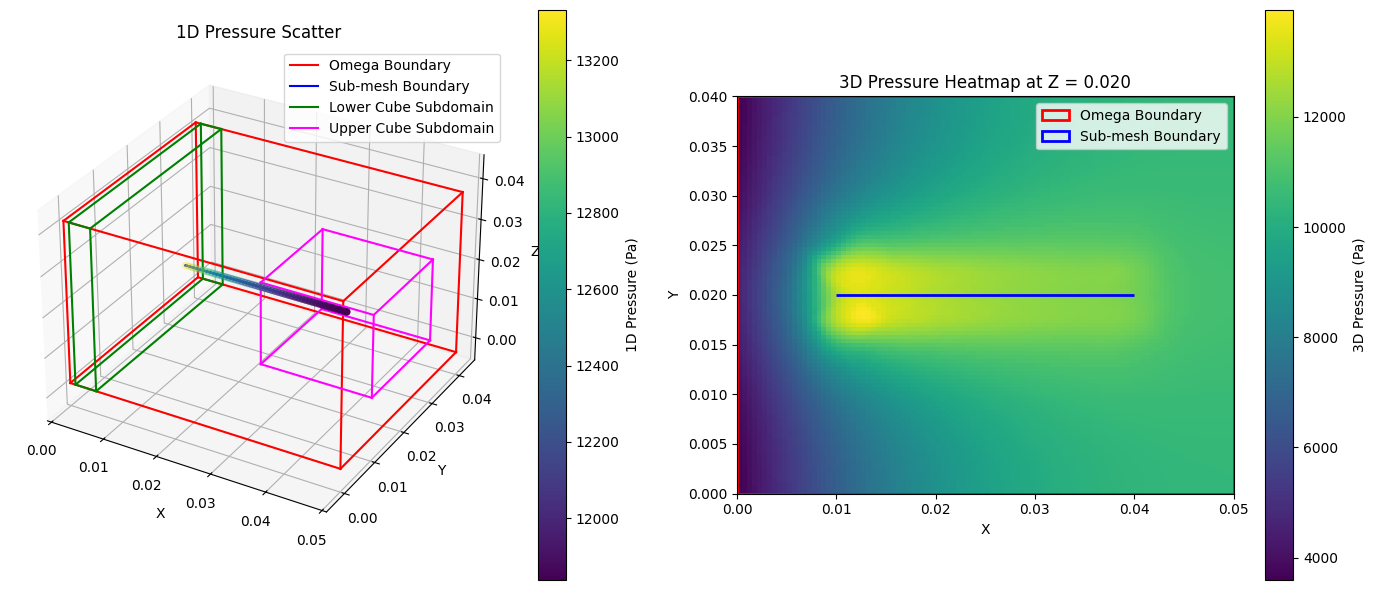

In [46]:
cube_lower_bounds = CUBES_TEST.lower_cube_bounds
cube_upper_bounds = CUBES_TEST.upper_cube_bounds

print("Lower Cube Bounds:", cube_lower_bounds)
print("Upper Cube Bounds:", cube_upper_bounds)

fig1 = visualize.plot_with_boundaries(CUBES_TEST.uh1d, CUBES_TEST.uh3d,
     cube_lower=cube_lower_bounds, 
     cube_upper=cube_upper_bounds)
fig1.show()

In [15]:
CUBES_TEST.print_diagnostics()

Flow Diagnostics
--------------------------------------------------
Sink Boundary:
  Inflow               : 0
  Outflow              : 6.1705274e-05
  Net Flow (sum)       : 6.1705274e-05
  Net Flow (Dolfin)    : 6.1705274e-05
  --> The 'Net Flow (sum)' should equal 'Net Flow (Dolfin)'.
--------------------------------------------------
Neumann Boundary:
  Net Flow (Dolfin)    : 3.1222501e-20
--------------------------------------------------
Entire Domain Boundary:
  Inflow               : -3.8534338e-06
  Outflow              : 6.5558708e-05
  Net Flow (sum)       : 6.1705274e-05
  Net Flow (Dolfin)    : 6.1705274e-05
  --> The 'Net Flow (sum)' should equal 'Net Flow (Dolfin)'.
--------------------------------------------------
Sum of dsOmegaNeumann and dsOmegaSink (Dolfin):
  Neumann + Sink       : 6.1705274e-05
  --> This should match the net flow over the entire domain boundary.
--------------------------------------------------


Node Pressure Data:
Node 0: Pressure 13332.2
Node 25: Pressure 13236.9
Node 13: Pressure 13159.4
Node 26: Pressure 13093.4
Node 7: Pressure 13032.4
Node 28: Pressure 12972.2
Node 14: Pressure 12912.1
Node 27: Pressure 12853.0
Node 4: Pressure 12796.3
Node 31: Pressure 12742.8
Node 16: Pressure 12691.9
Node 32: Pressure 12643.1
Node 8: Pressure 12596.3
Node 30: Pressure 12551.8
Node 15: Pressure 12509.6
Node 29: Pressure 12469.2
Node 1: Pressure 12430.4
Node 33: Pressure 12393.1
Node 17: Pressure 12357.5
Node 34: Pressure 12323.8
Node 9: Pressure 12291.6
Node 36: Pressure 12260.7
Node 18: Pressure 12231.1
Node 35: Pressure 12202.9
Node 5: Pressure 12176.2
Node 39: Pressure 12150.8
Node 20: Pressure 12126.4
Node 40: Pressure 12103.2
Node 10: Pressure 12081.1
Node 38: Pressure 12060.2
Node 19: Pressure 12040.4
Node 37: Pressure 12021.6
Node 2: Pressure 12003.7
Node 41: Pressure 11986.7
Node 21: Pressure 11970.8
Node 42: Pressure 11955.9
Node 11: Pressure 11941.8
Node 44: Pressure 11928.5


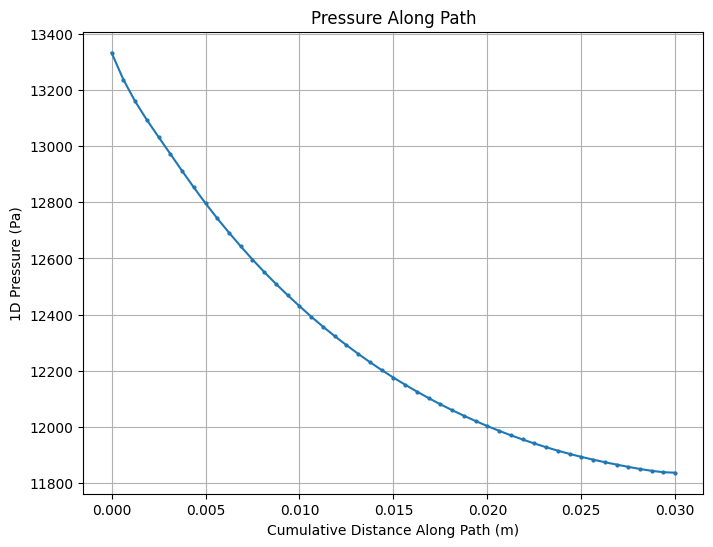

In [16]:
fig1 = visualize.plot_path_pressure(CUBES_TEST.uh1d, TEST_GRAPH, [0, 1, 2, 3])
fig1.show()

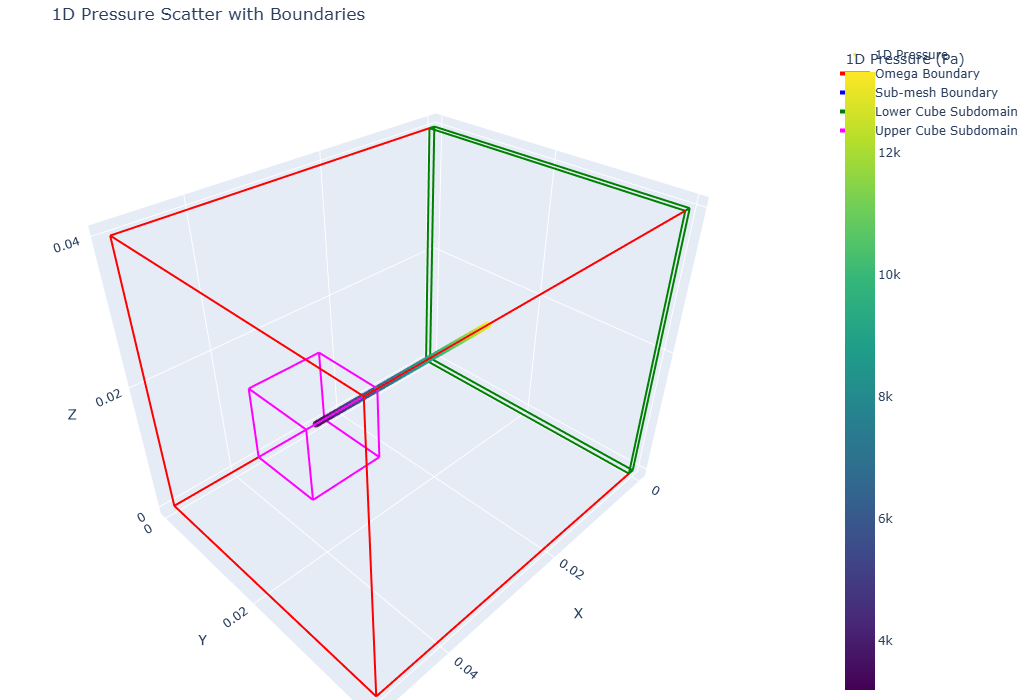

In [34]:
visualize.plot_with_boundaries_plotly(CUBES_TEST.uh1d, CUBES_TEST.uh3d,
     cube_lower=cube_lower_bounds, 
     cube_upper=cube_upper_bounds)

In [10]:
import datetime
import pytz

cst = pytz.timezone("America/Chicago")
now = datetime.datetime.now(cst)
timestamp = now.strftime("%Y%m%d_%H%M")
filename = f"straightline_output_{timestamp}"

SAVE_PATH = os.path.join(WORK_PATH, "export", filename)
CUBES_TEST.save_vtk(SAVE_PATH)